In [33]:
import pandas as pd
import spacy
import nltk
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

nlp = spacy.load('en_core_web_sm')

from nltk.tokenize import word_tokenize

nltk.download('punkt')
from nltk.corpus import stopwords

import string as str

from spacy.matcher import Matcher 
from spacy.tokens import Span


pd.set_option('display.max_colwidth', 200)
%matplotlib inline

[nltk_data] Downloading package punkt to /home/ali/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [34]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("DataSet/News_DS.csv")
candidate_sentences.shape

(99, 5)

In [35]:
candidate_sentences['Headline'].sample(5)

21    By George Georgiopoulos ATHENS (Reuters) - Greece's economy expanded slightly in the last three months of 2015, the country's statistics service said on Monday, revising flash estimates of a 0.6 p...
78     Microsoft/YouTube Microsoft hasÂ launched a new campaign for Windows 10 PCs, directly targeting Apple Macs. The videos feature two teachers â€” known as &quot; The Bug Chicks &quot; â€” being imp...
87     Microsoft has opened pre-orders for the developer edition of its HoloLens augmented reality headset. A webpage allowing developers secure a headset appeared on Microsoft's website on 29 February,...
28    New Delhi, Feb 29 (IANS) Focusing on rural economy and infrastructure with minor rebate for small taxpayers but amnesty for defaulters, Finance Minister Arun Jaitley on Monday unveiled a Rs.19.78 ...
63    Billionaire Warren Buffett said the U.S. economy appears weaker than he thought it would be as recently as last fall, but that doesn't change his optimistic long-term vie

In [36]:
#For Cleaning Data
# my name is hamza, ali. i'm student
def review_cleaning(text):
    tokens = word_tokenize(text.replace('-', ' ').replace('/',' '))
    tokens = [w.lower() for w in tokens if len(w.lower())>2]
    table = text.maketrans('', '', str.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    words = [word for word in stripped if word.isalpha() and word not in stop] 
    clean_text = ' '.join(words)

    return clean_text

In [37]:
def get_entities(sent):
  sent = review_cleaning(sent)
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent): # hamza, google, is, i'm, 
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [38]:
entity_pairs = []

for i in tqdm(candidate_sentences["Headline"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 99/99 [00:02<00:00, 33.91it/s]


In [39]:
entity_pairs[10:20]

[['ambitious  demo', 'dead project centennial'],
 ['parallel  trends', 'much  attention'],
 ['monday data', ''],
 ['big analytics internet iot', 'new business research cebr'],
 ['headset', 'bad fur day'],
 ['mac', ''],
 ['originally  device', 'buyers'],
 ['long project developers', 'desktop apps ones'],
 ['three country statistics service', 'monday estimates percent decline'],
 ['awful news sweden economy', 'fantastic central bank riksbank']]

In [40]:
def get_relation(sent):
  sent = review_cleaning(sent)
  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 


  matcher.add("matching_1", [pattern], on_match=None)
  matches = matcher(doc)
  #print("Matches -> ",matches)
  #print("Length of match",len(matches) - 1)
  k = len(matches) - 1
  #print("Len of K ", k)
  #print("Matches ", matches)
  #print("Matches k1",matches[k][1])
  #print("Matches k2",matches[k][2])
  
  #print("DOC of Matches k1",doc[matches[k][1]])
  #print("DOC of Matches k2",doc[matches[k][2]])
  #print("DOC of Matches k3",doc[matches[k][3]])

  #print(f"DOC ranges:K1 {doc[matches[k][1]]} and K2 {doc[matches[k][2]]}. ")
  #print("Matches ->", [doc[start:end].text for match_id, start, end in matches])

  span = doc[matches[k][1]:matches[k][2]] 
  
  #print("SPAN.text",doc[matches[k][1]:matches[k][2]].text)
  #print(span.text)
  return(span.text)

In [41]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['Headline'])]

100%|██████████| 99/99 [00:02<00:00, 35.73it/s]


In [42]:
pd.Series(relations).value_counts()[:50]

says                8
said                6
announced           5
hololens            4
augmented           4
opened              4
barack              4
launched new        3
released            2
start               2
showed              2
got                 2
unveiled            2
cut                 2
irked               2
prevent             1
batch               1
read                1
break               1
wants               1
confirmed           1
contributed         1
lays                1
targeted            1
debuted             1
take                1
apis responsible    1
begun               1
starts              1
believes            1
feature             1
appears             1
announced new       1
released new        1
goes                1
march plenty        1
seemed              1
shipped             1
invites             1
discusses           1
explains global     1
spending            1
expected            1
expressed           1
speaks              1
lost      

In [43]:

# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df

,source,target,edge
0,national cemetery president,tomb unknowns wreath tomb honor,lays
1,fixed income gam,book state economy,discusses
2,global economy,nt conditions,explains global
3,preliminary figures statistics finland,,showed
4,,private bank thailand data,spending
...,...,...,...
94,growing,back hamilton set motion,goes
95,games complement development tools,developer site,announced
96,hardware post developers,microsoft hololens,march plenty
97,futuresource,momentum,indicates despite


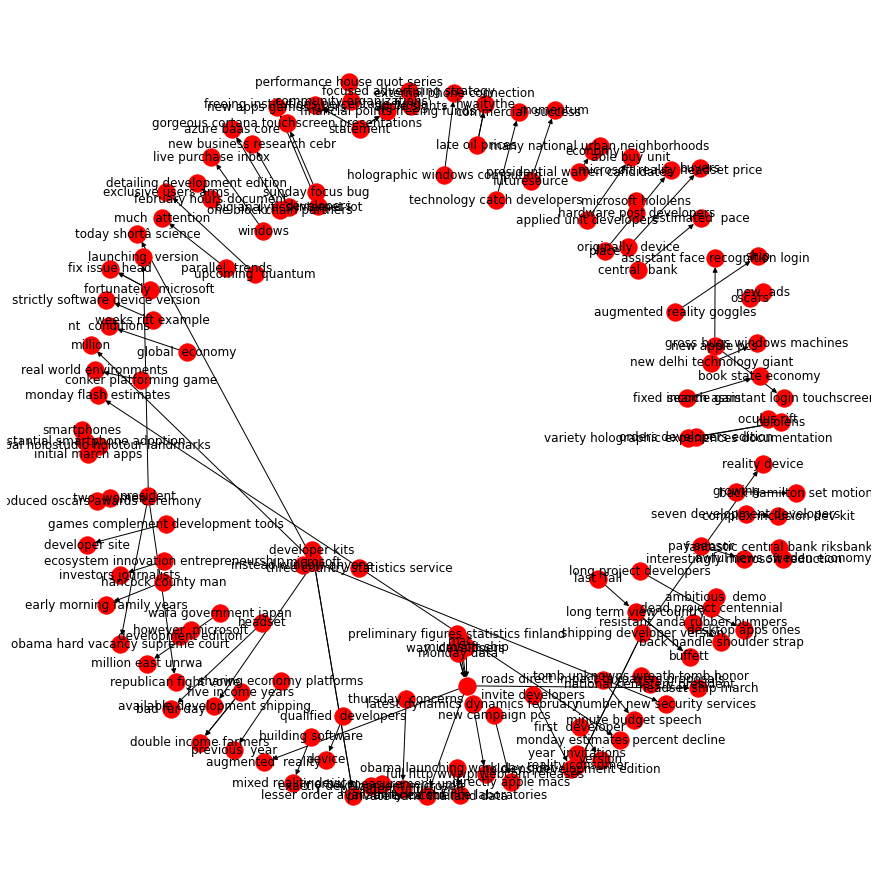

In [53]:
# create a directed-graph from a dataframe
#plotting all relations
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True,create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()


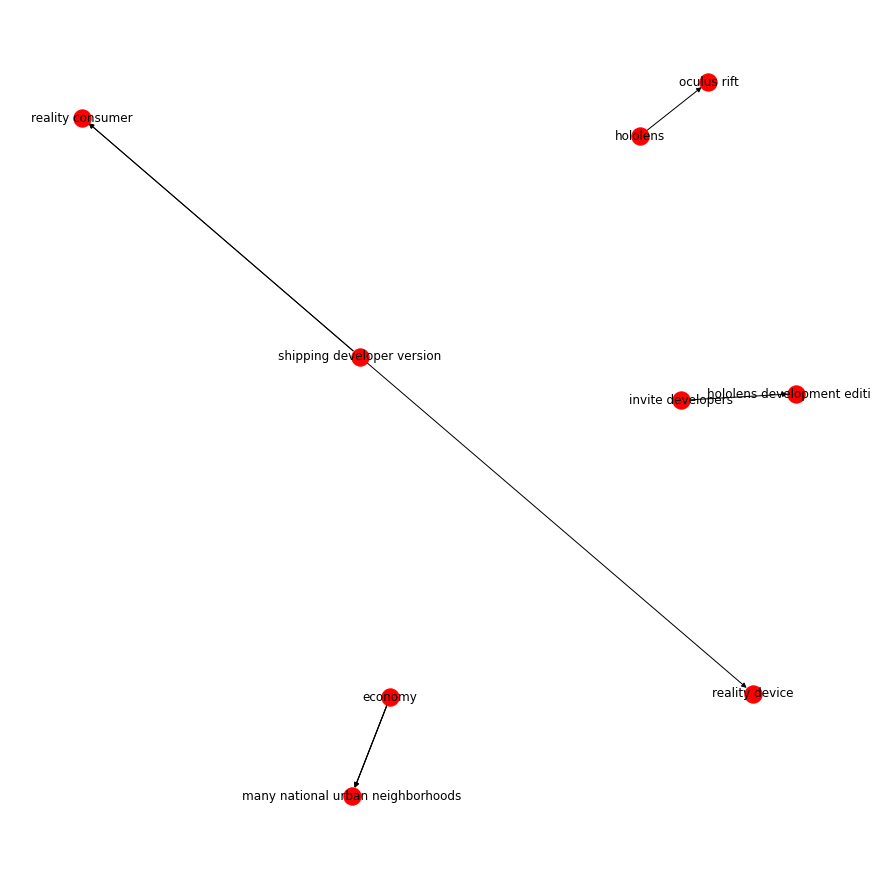

In [54]:
#plotting specific relations
G=nx.from_pandas_edgelist(kg_df[kg_df['edge'] == 'says'], "source", "target", 
                          edge_attr=True,create_using=nx.MultiDiGraph())


plt.figure(figsize=(12,12))
pos = nx.   t(G)
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()